In [2]:
import pandas as pd

kdd_df = pd.read_csv("kddcup_dataset.csv", index_col=None)

In [3]:
kdd_df.head()

,duration,"""protocol_type""","""flag""","""src_bytes""","""dst_bytes""","""land""","""wrong_fragment""","""urgent""",hot,"""num_failed_logins""",...,"""dst_host_srv_count""","""dst_host_same_srv_rate""","""dst_host_diff_srv_rate""","""dst_host_same_src_port_rate""","""dst_host_srv_diff_host_rate""",dst_host_serror_rate,"""dst_host_srv_serror_rate""","""dst_host_rerror_rate""","""dst_host_srv_rerror_rate""",label
0,0,tcp,SF,223,185,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal
1,0,tcp,SF,230,260,0,0,0,0,0,...,255,1,0,33,7,33,0,0,0,normal
2,0,tcp,SF,297,13787,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal
3,0,tcp,SF,291,3542,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal
4,0,tcp,SF,295,753,0,0,0,0,0,...,255,1,0,1,1,0,0,0,0,normal


In [4]:
kdd_df.shape

(41237, 41)

In [5]:
y = kdd_df["label"].values
from collections import Counter

Counter(y).most_common()

[('normal', 39247),
 ('back', 1098),
 ('apache2', 794),
 ('neptune', 93),
 ('phf', 2),
 ('portsweep', 2),
 ('saint', 1)]

In [6]:
def label_anomalous(text):
    """Binarize target labels into normal or anomalous."""
    if text == "normal":
        return 0
    else:
        return 1

In [7]:
kdd_df["label"] = kdd_df["label"].apply(label_anomalous)

In [8]:
y = kdd_df["label"].values
counts = Counter(y).most_common()
contamination_parameter = counts[1][1] / (counts[0][1] + counts[1][1])

In [9]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in kdd_df.columns:
    if kdd_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        kdd_df[c] = encodings_dictionary[c].fit_transform(kdd_df[c])

In [10]:
kdd_df_normal = kdd_df[kdd_df["label"] == 0]
kdd_df_abnormal = kdd_df[kdd_df["label"] == 1]

In [11]:
y_normal = kdd_df_normal.pop("label").values
X_normal = kdd_df_normal.values
y_anomaly = kdd_df_abnormal.pop("label").values
X_anomaly = kdd_df_abnormal.values

In [12]:
from sklearn.model_selection import train_test_split

X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
    X_normal, y_normal, test_size=0.3, random_state=11
)

In [13]:
X_anomaly_train, X_anomaly_test, y_anomaly_train, y_anomaly_test = train_test_split(
    X_anomaly, y_anomaly, test_size=0.3, random_state=11
)

In [14]:
import numpy as np

X_train = np.concatenate((X_normal_train, X_anomaly_train))
y_train = np.concatenate((y_normal_train, y_anomaly_train))
X_test = np.concatenate((X_normal_test, X_anomaly_test))
y_test = np.concatenate((y_normal_test, y_anomaly_test))

In [15]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(contamination=contamination_parameter)

In [16]:
IF.fit(X_train)

IsolationForest(contamination=0.04825763270848995)

In [17]:
decisionScores_train_normal = IF.decision_function(X_normal_train)
decisionScores_train_anomaly = IF.decision_function(X_anomaly_train)

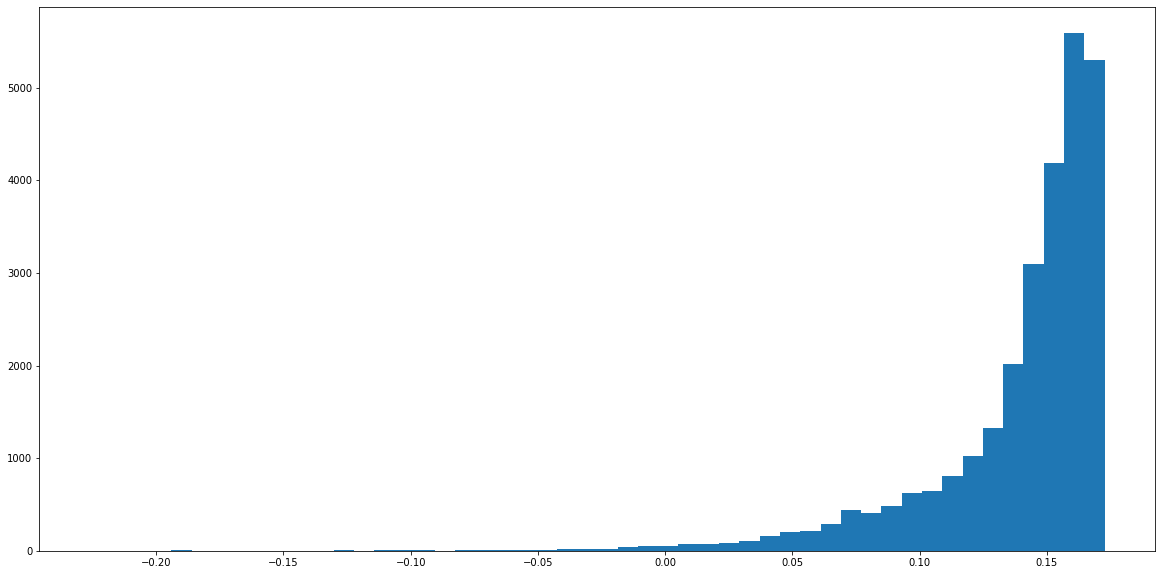

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(20, 10))
_ = plt.hist(decisionScores_train_normal, bins=50)

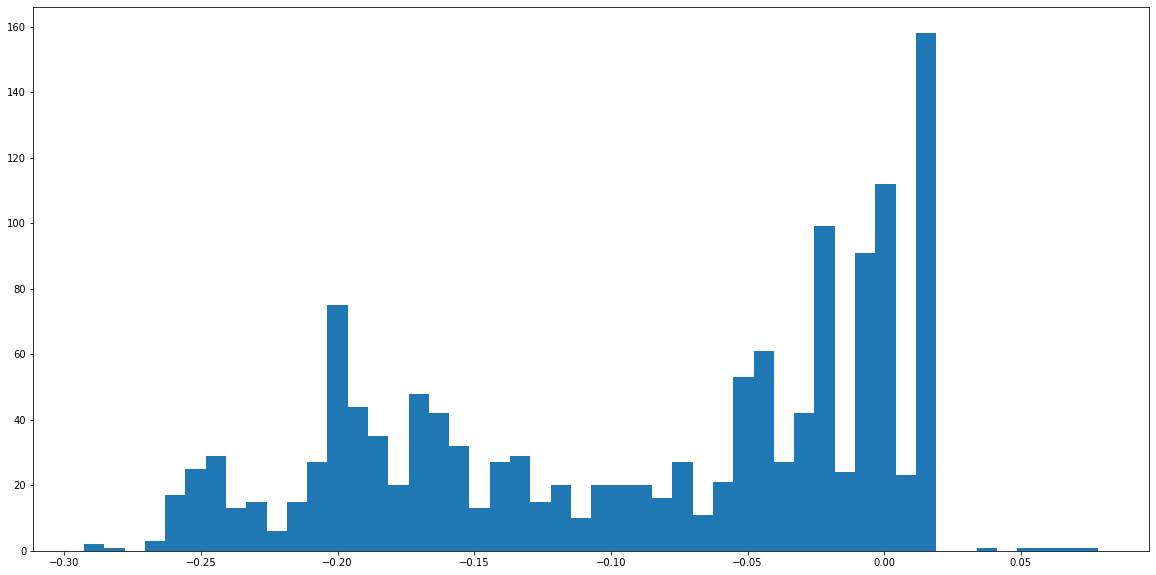

In [20]:
plt.figure(figsize=(20, 10))
_ = plt.hist(decisionScores_train_anomaly, bins=50)

In [21]:
cutoff = 0

In [22]:
print(Counter(y_test))
print(Counter(y_test[cutoff > IF.decision_function(X_test)]))

Counter({0: 11775, 1: 597})
Counter({1: 488, 0: 87})


In [23]:
print(X_test)

[[  0   0   7 ...   0   0   0]
 [  0   0   7 ...   1   0   0]
 [  0   0   7 ...   0   0   0]
 ...
 [  0   0   7 ...   0   5   6]
 [805   0   2 ...   0  18  19]
 [  0   0   3 ...  25   7   7]]
